# Imports

In [194]:
import pandas as pd
import numpy as np

import networkx as nx

from karateclub import DeepWalk 
from karateclub import Node2Vec

import matplotlib.pyplot as plt

%matplotlib inline

## Load `e_coli_core` from cobra for reference

In [195]:
from cobra.io import load_model

model = load_model('textbook')
model

Name,e_coli_core
Memory address,7f8ce8fee6d0
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


## Load edge list file

In [196]:
df = pd.read_csv('../data/queries/e_coli_edge_list.csv')
df.rename(columns = {'[reaction]':'source', 'met': 'target'}, inplace = True)

for col in df.columns:
    df[col] = df[col].apply(lambda row : row[3:] )

df

,source,target
0,reaction_acald,metabolite_coa_c
1,reaction_acald,metabolite_acald_c
2,reaction_acald,metabolite_nad_c
3,reaction_acald,metabolite_h_c
4,reaction_acald,metabolite_accoa_c
...,...,...
1222,metabolite_succ_c,metabolite_h_c
1223,metabolite_succ_c,metabolite_fum_c
1224,metabolite_succ_c,metabolite_q8h2_c
1225,metabolite_succ_e,metabolite_succ_c


### Keep `source` / `target` types (metabolite / reaction)

In [197]:
df['source_type'] = df['source'].apply(lambda row : row.split('_')[0])
df['target_type'] = df['target'].apply(lambda row : row.split('_')[0])

for col in ['source', 'target']:
    df[col] = df[col].apply(lambda row : row.replace('metabolite_', ''))
    df[col] = df[col].apply(lambda row : row.replace('reaction_', ''))    

df.head()

,source,target,source_type,target_type
0,acald,coa_c,reaction,metabolite
1,acald,acald_c,reaction,metabolite
2,acald,nad_c,reaction,metabolite
3,acald,h_c,reaction,metabolite
4,acald,accoa_c,reaction,metabolite


### Which `metabolites` / `reactions` are missing from the `graph`?

In [198]:
def report(met_or_rxn):
    m_s = df[df['target_type'] == met_or_rxn]['target'].unique()
    m_t = df[df['source_type'] == met_or_rxn]['source'].unique()

    print("GRAPH'S "+met_or_rxn+":")
    elements = np.append(m_s, m_t)
    print(np.unique(elements))
    print(len(np.unique(elements)))

    print('\n')

    print("COBRA'S "+met_or_rxn+":")
    
    if met_or_rxn == 'metabolite':
        cobra_elements = [m.id for m in model.metabolites]
        cobra_elements = [i.lower() for i in cobra_elements]
        print(np.array(cobra_elements))
        print(len(np.array(cobra_elements)))
    elif met_or_rxn == 'reaction':
        cobra_elements = [m.id for m in model.reactions]
        cobra_elements = [i.lower() for i in cobra_elements]
        print(np.array(cobra_elements))
        print(len(np.array(cobra_elements)))
    
    print('\n')
    
    # The missing metabolites are:
    print('UNCOMMON VALUES:')
    uncommon_values = set(elements) ^ set(cobra_elements)
    print(uncommon_values) 

    print('\n')

    # The common metabolites are:
    print('COMMON VALUES:')
    common_values = set(elements) & set(cobra_elements)
    print(common_values)

In [199]:
report('metabolite')

GRAPH'S metabolite:
['13dpg_c' '2pg_c' '3pg_c' '6pgc_c' '6pgl_c' 'ac_c' 'ac_e' 'acald_c'
 'acald_e' 'accoa_c' 'acon_C_c' 'actp_c' 'adp_c' 'akg_c' 'akg_e' 'amp_c'
 'atp_c' 'cit_c' 'co2_c' 'co2_e' 'coa_c' 'dhap_c' 'e4p_c' 'etoh_c'
 'etoh_e' 'f6p_c' 'fdp_c' 'for_c' 'for_e' 'fru_e' 'fum_c' 'fum_e' 'g3p_c'
 'g6p_c' 'gln__L_c' 'glu__L_c' 'h2o_c' 'h2o_e' 'h_c' 'h_e' 'icit_c'
 'lac__D_c' 'mal__L_c' 'nad_c' 'nadh_c' 'nadp_c' 'nadph_c' 'nh4_c' 'nh4_e'
 'o2_c' 'o2_e' 'oaa_c' 'pep_c' 'pi_c' 'pi_e' 'pyr_c' 'pyr_e' 'q8_c'
 'q8h2_c' 'r5p_c' 'ru5p__D_c' 's7p_c' 'succ_c' 'succ_e' 'succoa_c'
 'xu5p__D_c']
66


COBRA'S metabolite:
['13dpg_c' '2pg_c' '3pg_c' '6pgc_c' '6pgl_c' 'ac_c' 'ac_e' 'acald_c'
 'acald_e' 'accoa_c' 'acon_c_c' 'actp_c' 'adp_c' 'akg_c' 'akg_e' 'amp_c'
 'atp_c' 'cit_c' 'co2_c' 'co2_e' 'coa_c' 'dhap_c' 'e4p_c' 'etoh_c'
 'etoh_e' 'f6p_c' 'fdp_c' 'for_c' 'for_e' 'fru_e' 'fum_c' 'fum_e' 'g3p_c'
 'g6p_c' 'glc__d_e' 'gln__l_c' 'gln__l_e' 'glu__l_c' 'glu__l_e' 'glx_c'
 'h2o_c' 'h2o_e' 'h_c' 'h

In [200]:
report('reaction')

GRAPH'S reaction:
['acald' 'acaldt' 'ackr' 'aconta' 'acontb' 'act2r' 'adk1' 'akgdh' 'akgt2r'
 'alcd2x' 'atpm' 'atps4r' 'biomass_ecoli_core_w_gam' 'co2t' 'cs' 'cytbd'
 'd_lact2' 'eno' 'etoht2r' 'ex_ac_e' 'ex_acald_e' 'ex_akg_e' 'ex_co2_e'
 'ex_etoh_e' 'ex_for_e' 'ex_fru_e' 'ex_fum_e' 'ex_h2o_e' 'ex_h_e'
 'ex_nh4_e' 'ex_o2_e' 'ex_pi_e' 'ex_pyr_e' 'ex_succ_e' 'fba' 'fbp' 'fort'
 'fort2' 'frd7' 'frupts2' 'fum' 'fumt2_2' 'g6pdh2r' 'gapd' 'glcpts'
 'glnabc' 'glns' 'gludy' 'glun' 'glusy' 'glut2r' 'gnd' 'h2ot' 'icdhyr'
 'icl' 'ldh_d' 'mals' 'malt2_2' 'mdh' 'me1' 'me2' 'nadh16' 'nadtrhd'
 'nh4t' 'o2t' 'pdh' 'pgi' 'pgk' 'pgl' 'pgm' 'pit2r' 'ppc' 'pps' 'ptar'
 'pyk' 'pyrt2' 'rpe' 'rpi' 'succt2_2' 'succt3' 'sucdi' 'sucoas' 'tala'
 'thd2' 'tkt1' 'tkt2' 'tpi']
87


COBRA'S reaction:
['acald' 'acaldt' 'ackr' 'aconta' 'acontb' 'act2r' 'adk1' 'akgdh' 'akgt2r'
 'alcd2x' 'atpm' 'atps4r' 'biomass_ecoli_core' 'co2t' 'cs' 'cytbd'
 'd_lact2' 'eno' 'etoht2r' 'ex_ac_e' 'ex_acald_e' 'ex_akg_e' 'ex_co2_e'
 'ex_e

## Create Graph from `edge_list`

#### Create a `df` only with `metabolite -> metabolite` relationships

In [201]:
df_met_to_met = df[(df['source_type'] == 'metabolite') & (df['target_type'] == 'metabolite')]

#### Create Graph

In [202]:
G = nx.from_pandas_edgelist(df_met_to_met, source='source', target='target',
                           create_using=nx.DiGraph)
print(G.is_directed())

True


In [203]:
G.number_of_nodes()

65

In [204]:
G.number_of_edges()

295

### Plot Graph

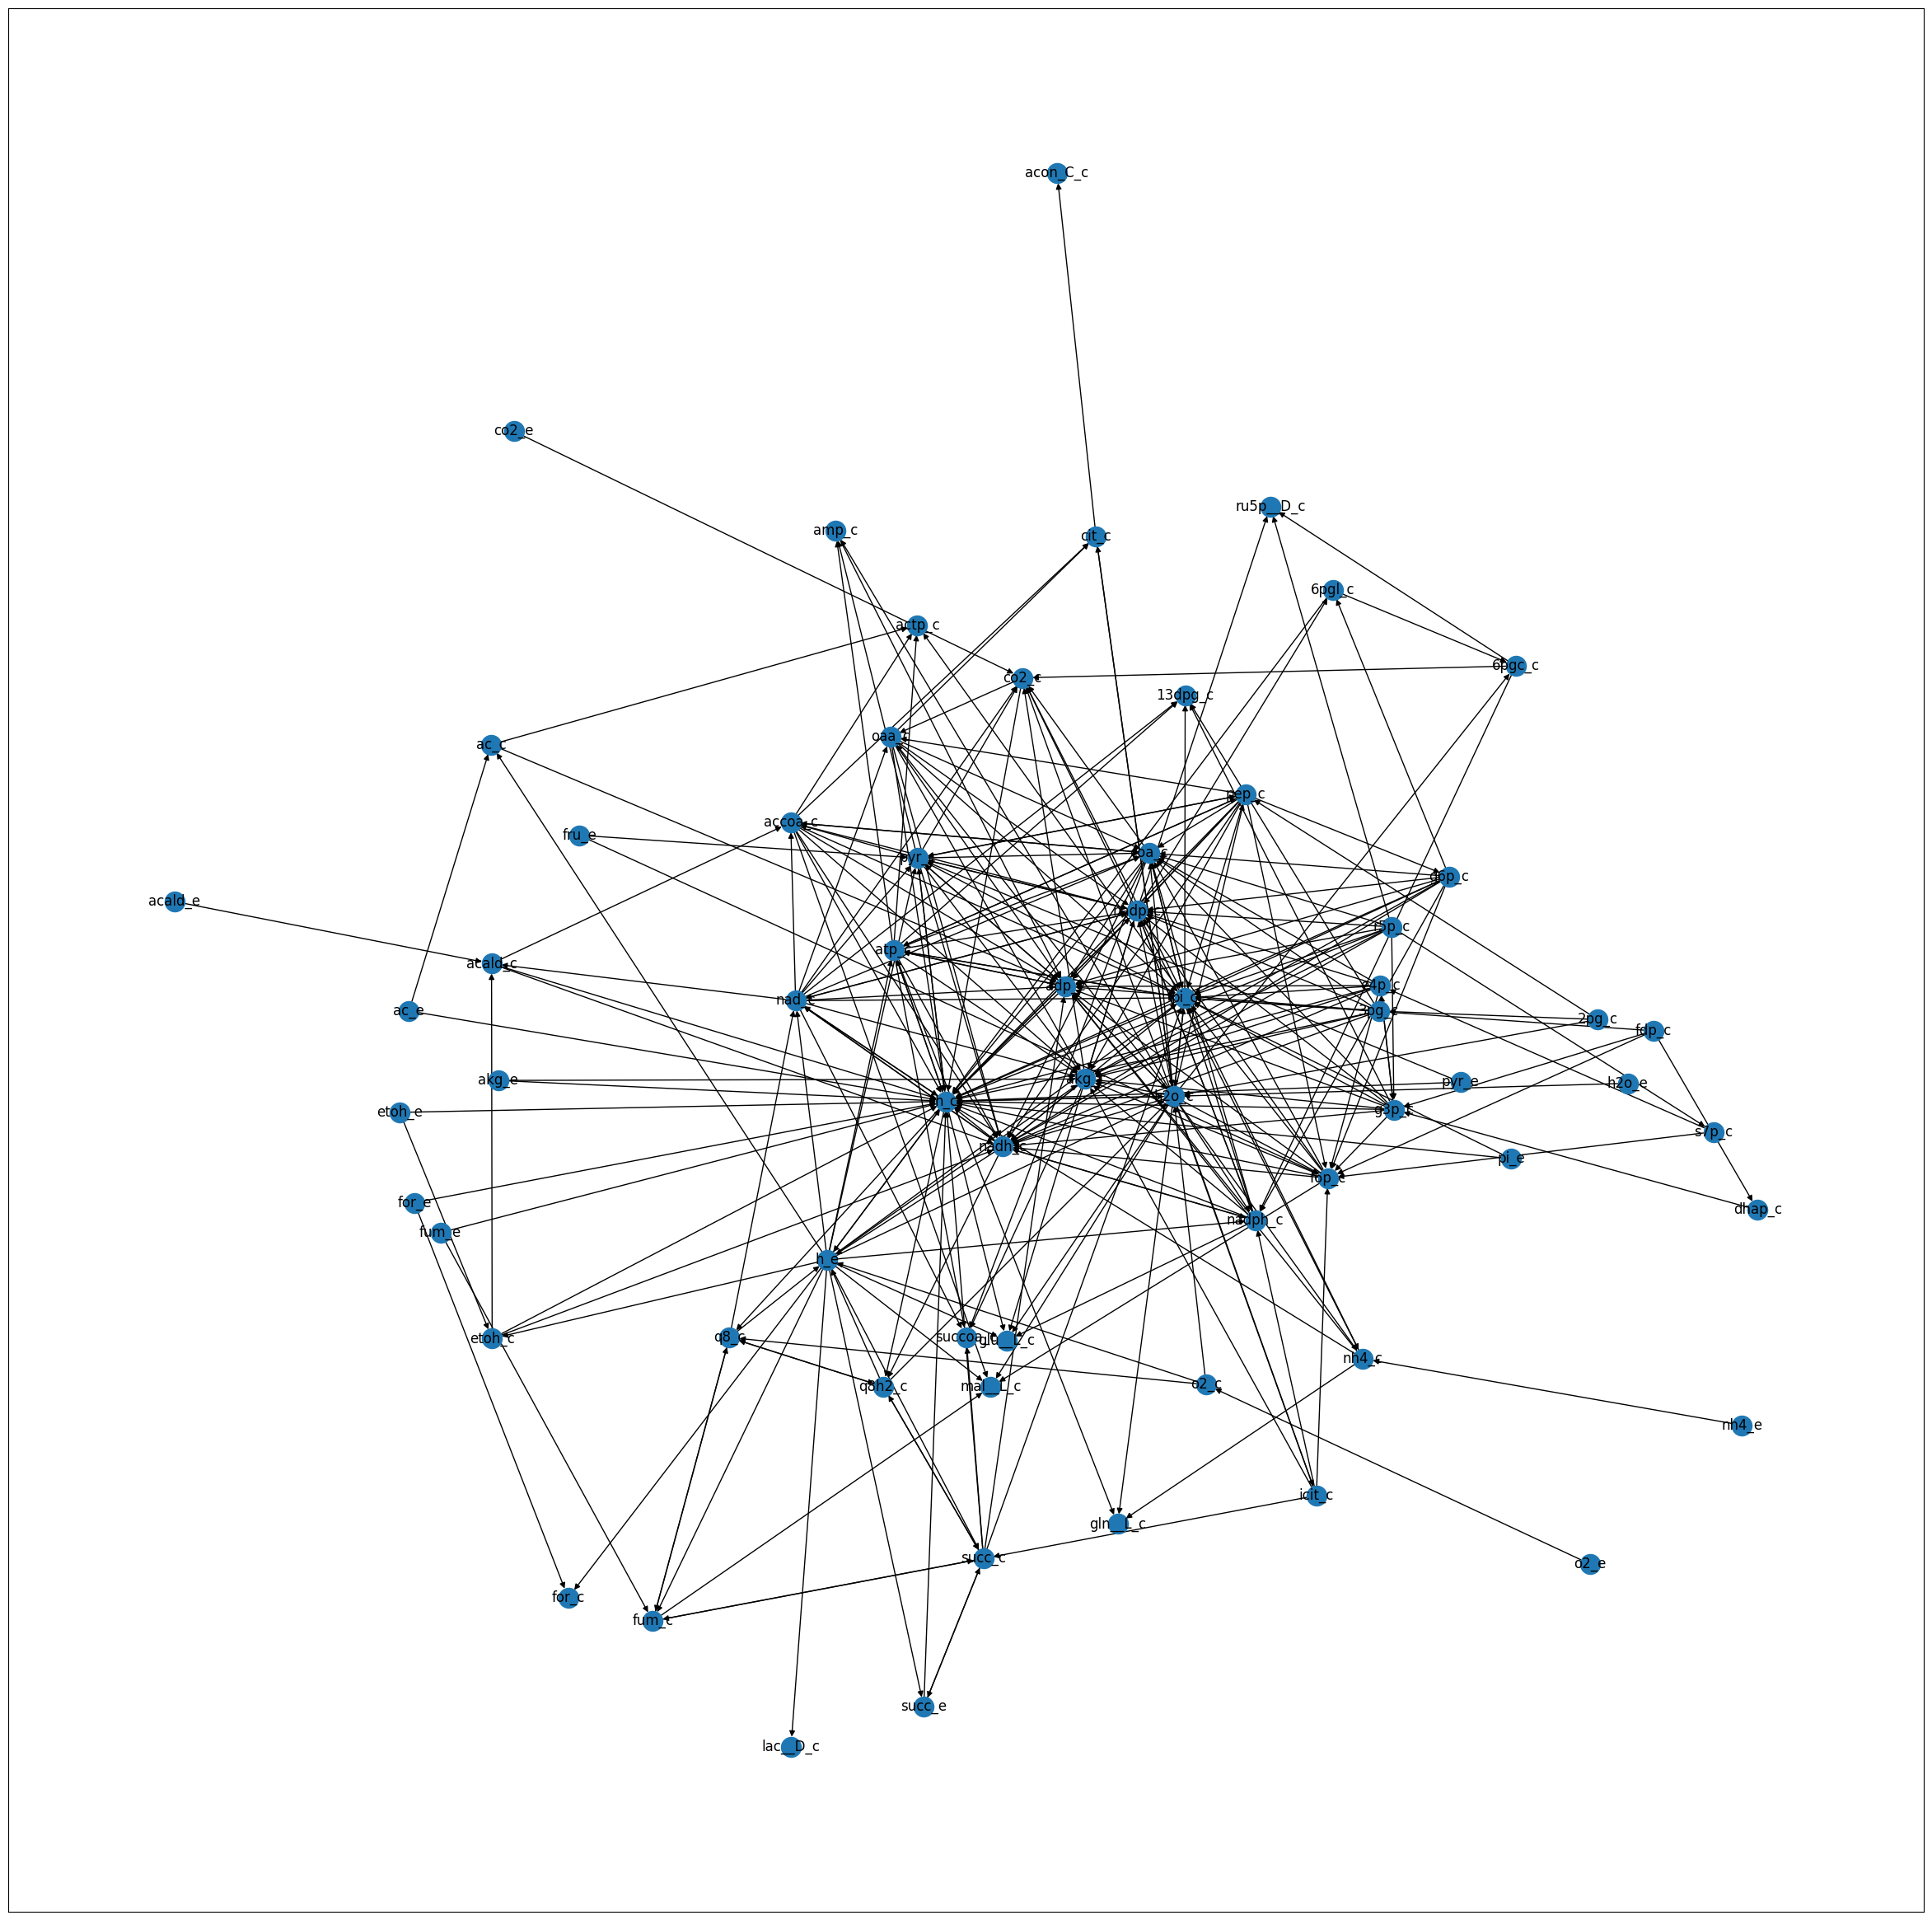

In [207]:
plt.figure(figsize=(30,30))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos)

In [22]:
import networkx as nx
 
G=nx.MultiGraph()
G.add_node('A',role='manager')
G.add_edge('A','B',relation = 'friend')
G.add_edge('A','C', relation = 'business partner')
G.add_edge('A','B', relation = 'classmate')
G.nodes['A']['role'] = 'team member'
G.nodes['B']['role'] = 'engineer'

In [24]:
G.nodes['A']

{'role': 'team member'}

source 69
target 122


In [18]:
print(every_element.nunique())

134


In [19]:
G = nx.from_numpy_array(df)

NetworkXError: Adjacency matrix not square: nx,ny=(609, 2)

In [6]:
import numpy as np

print(len(np.unique(reactions)))
print(len(np.unique(metabolites)))

69
51


In [7]:
np.unique(reactions)

array(['acald', 'acaldt', 'ackr', 'aconta', 'acontb', 'act2r', 'adk1',
       'akgdh', 'akgt2r', 'alcd2x', 'atpm', 'atps4r', 'co2t', 'cs',
       'cytbd', 'd', 'eno', 'etoht2r', 'fba', 'fbp', 'fort', 'fort2',
       'frd7', 'frupts2', 'fum', 'fumt2', 'g6pdh2r', 'gapd', 'glcpts',
       'glnabc', 'glns', 'gludy', 'glun', 'glusy', 'glut2r', 'gnd',
       'h2ot', 'icdhyr', 'icl', 'ldh', 'mals', 'mdh', 'me1', 'me2',
       'nadh16', 'nadtrhd', 'nh4t', 'o2t', 'pdh', 'pgi', 'pgk', 'pgl',
       'pgm', 'pit2r', 'ppc', 'pps', 'ptar', 'pyk', 'pyrt2', 'rpi',
       'succt2', 'succt3', 'sucdi', 'sucoas', 'tala', 'thd2', 'tkt1',
       'tkt2', 'tpi'], dtype='<U7')

In [8]:
np.unique(metabolites)

array(['13dpg', '2pg', '3pg', '6pgc', '6pgl', 'ac', 'acald', 'accoa',
       'acon', 'actp', 'adp', 'akg', 'amp', 'atp', 'cit', 'co2', 'coa',
       'dhap', 'e4p', 'etoh', 'f6p', 'fdp', 'for', 'fru', 'fum', 'g3p',
       'g6p', 'gln', 'glu', 'h', 'h2o', 'icit', 'lac', 'mal', 'nad',
       'nadh', 'nadp', 'nadph', 'nh4', 'o2', 'oaa', 'pep', 'pi', 'pyr',
       'q8', 'q8h2', 'r5p', 'ru5p', 's7p', 'succ', 'succoa'], dtype='<U6')

### PageRank

In [86]:
from operator import itemgetter

pagerank_dict = nx.pagerank(G)
sorted_pagerank = sorted(pagerank_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by page rank:")
for b in sorted_pagerank[:20]:
    print(b)

Top 20 nodes by page rank:
('reaction_pyk', 0.029279537350687952)
('reaction_glusy', 0.02716410677443988)
('metabolite_h_c', 0.02247458755662256)
('reaction_cytbd', 0.020758119748060154)
('reaction_nadh16', 0.019410153561661377)
('reaction_atps4r', 0.018606386191899468)
('reaction_mals', 0.01827254090286899)
('reaction_ppc', 0.01823789963329636)
('reaction_gapd', 0.018162638558963284)
('reaction_pps', 0.018032246105822786)
('reaction_cs', 0.014423998426546708)
('reaction_pdh', 0.014243082712309528)
('reaction_eno', 0.01420944194375141)
('metabolite_h2o_c', 0.01261899828196938)
('reaction_aconta', 0.01249493554274772)
('reaction_acald', 0.012415745651212546)
('reaction_gludy', 0.012280656074065303)
('reaction_sucoas', 0.012016198240572106)
('reaction_glns', 0.011970519525019952)
('reaction_thd2', 0.011885928148285775)


In [10]:
from cobra.io import load_model

model = load_model('textbook')

In [11]:
model

Name,e_coli_core
Memory address,7fd5495134c0
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [14]:
model.reactions.Biomass_Ecoli_core.metabolites

{<Metabolite 3pg_c at 0x7fd549513cd0>: -1.496,
 <Metabolite accoa_c at 0x7fd549513fd0>: -3.7478,
 <Metabolite atp_c at 0x7fd54f010df0>: -59.81,
 <Metabolite e4p_c at 0x7fd549513af0>: -0.361,
 <Metabolite f6p_c at 0x7fd54e2c5d30>: -0.0709,
 <Metabolite g3p_c at 0x7fd549786100>: -0.129,
 <Metabolite g6p_c at 0x7fd549786640>: -0.205,
 <Metabolite gln__L_c at 0x7fd5497868b0>: -0.2557,
 <Metabolite glu__L_c at 0x7fd549786850>: -4.9414,
 <Metabolite h2o_c at 0x7fd5497869d0>: -59.81,
 <Metabolite nad_c at 0x7fd549786ac0>: -3.547,
 <Metabolite nadph_c at 0x7fd549786b80>: -13.0279,
 <Metabolite oaa_c at 0x7fd549786c70>: -1.7867,
 <Metabolite pep_c at 0x7fd549786d60>: -0.5191,
 <Metabolite pyr_c at 0x7fd54ec8bb80>: -2.8328,
 <Metabolite r5p_c at 0x7fd5495302b0>: -0.8977,
 <Metabolite adp_c at 0x7fd54f0108b0>: 59.81,
 <Metabolite akg_c at 0x7fd549513be0>: 4.1182,
 <Metabolite coa_c at 0x7fd54e2c5d00>: 3.7478,
 <Metabolite h_c at 0x7fd549786970>: 59.81,
 <Metabolite nadh_c at 0x7fd549786af0>: 3.54

In [12]:
model.metabolites

[<Metabolite 13dpg_c at 0x7fd549513b20>,
 <Metabolite 2pg_c at 0x7fd549513c40>,
 <Metabolite 3pg_c at 0x7fd549513cd0>,
 <Metabolite 6pgc_c at 0x7fd549513f10>,
 <Metabolite 6pgl_c at 0x7fd549513fa0>,
 <Metabolite ac_c at 0x7fd549513eb0>,
 <Metabolite ac_e at 0x7fd549513d00>,
 <Metabolite acald_c at 0x7fd549513ee0>,
 <Metabolite acald_e at 0x7fd549513e20>,
 <Metabolite accoa_c at 0x7fd549513fd0>,
 <Metabolite acon_C_c at 0x7fd549513f40>,
 <Metabolite actp_c at 0x7fd549513e50>,
 <Metabolite adp_c at 0x7fd54f0108b0>,
 <Metabolite akg_c at 0x7fd549513be0>,
 <Metabolite akg_e at 0x7fd549513dc0>,
 <Metabolite amp_c at 0x7fd549513df0>,
 <Metabolite atp_c at 0x7fd54f010df0>,
 <Metabolite cit_c at 0x7fd54f010790>,
 <Metabolite co2_c at 0x7fd54f010d00>,
 <Metabolite co2_e at 0x7fd54f010880>,
 <Metabolite coa_c at 0x7fd54e2c5d00>,
 <Metabolite dhap_c at 0x7fd54e2c5940>,
 <Metabolite e4p_c at 0x7fd549513af0>,
 <Metabolite etoh_c at 0x7fd54f010af0>,
 <Metabolite etoh_e at 0x7fd54e2c5f10>,
 <Metaboli

In [26]:
import networkx as nx
from networkx import from_pandas_edgelist

G = from_pandas_edgelist(df, source='source', target='target', create_using=nx.Graph())
print('# nodes =',len(G.nodes))
print('# edges =',len(G.edges))

# nodes = 134
# edges = 546


NodeView(('reaction_acald', 'metabolite_acald_c', 'metabolite_coa_c', 'metabolite_nad_c', 'reaction_acaldt', 'metabolite_acald_e', 'reaction_ackr', 'metabolite_ac_c', 'metabolite_atp_c', 'reaction_aconta', 'metabolite_cit_c', 'reaction_acontb', 'metabolite_h2o_c', 'reaction_act2r', 'metabolite_ac_e', 'metabolite_h_e', 'reaction_adk1', 'metabolite_amp_c', 'reaction_akgdh', 'metabolite_akg_c', 'reaction_akgt2r', 'metabolite_akg_e', 'reaction_alcd2x', 'metabolite_etoh_c', 'reaction_atpm', 'reaction_atps4r', 'metabolite_adp_c', 'metabolite_pi_c', 'reaction_co2t', 'metabolite_co2_e', 'reaction_cs', 'metabolite_accoa_c', 'metabolite_oaa_c', 'reaction_cytbd', 'metabolite_q8h2_c', 'reaction_d_lact2', 'reaction_eno', 'metabolite_2pg_c', 'reaction_etoht2r', 'metabolite_etoh_e', 'reaction_fba', 'metabolite_fdp_c', 'reaction_fbp', 'reaction_fort', 'metabolite_for_e', 'reaction_fort2', 'reaction_frd7', 'metabolite_fum_c', 'reaction_frupts2', 'metabolite_pep_c', 'metabolite_fru_e', 'reaction_fum', '

In [4]:
df = pd.read_csv('../data/queries/query-result.csv', delimiter=';')

df.rename(columns = {'s':'source', 'o': 'target'}, inplace = True)

df.head()

,source,target
0,kg:reaction_acald,kg:reaction_cs
1,kg:reaction_acald,kg:reaction_mals
2,kg:reaction_acald,kg:reaction_ptar
3,kg:reaction_acald,kg:reaction_glusy
4,kg:reaction_acald,kg:reaction_pyk


In [5]:
df.shape

(358, 2)

In [7]:
metabolites = pd.read_csv('../data/queries/e.coli core data - metabolites.csv')
reactions = pd.read_csv('../data/queries/e.coli core data - reactions.csv')

In [19]:
metabolites

,[metabolite],metabolitel,st,reaction,reactionl
0,kg:metabolite_13dpg_c,3-Phospho-D-glyceroyl phosphate,1.0,kg:reaction_pgk,PGK
1,kg:metabolite_13dpg_c,3-Phospho-D-glyceroyl phosphate,1.0,kg:reaction_gapd,GAPD
2,kg:metabolite_2pg_c,D-Glycerate 2-phosphate,-1.0,kg:reaction_pgm,PGM
3,kg:metabolite_2pg_c,D-Glycerate 2-phosphate,-1.0,kg:reaction_eno,ENO
4,kg:metabolite_3pg_c,3-Phospho-D-glycerate,1.0,kg:reaction_pgm,PGM
...,...,...,...,...,...
304,kg:metabolite_succ_e,Succinate,1.0,kg:reaction_succt3,SUCCt3
305,kg:metabolite_succ_e,Succinate,-1.0,kg:reaction_succt2_2,SUCCt2_2
306,kg:metabolite_succ_e,Succinate,-1.0,kg:reaction_ex_succ_e,EX_succ_e
307,kg:metabolite_succoa_c,Succinyl-CoA,1.0,kg:reaction_sucoas,SUCOAS


## Create Graph

In [15]:
'''
Reactions names to integer ID
'''
from sklearn.preprocessing import LabelEncoder

rxn = pd.concat([df['source'], df['target']])

le = LabelEncoder()
le.fit_transform(rxn)

df['source'] = le.transform(df['source'])
df['target'] = le.transform(df['target'])

In [16]:
import networkx as nx
from networkx import from_pandas_edgelist

G = from_pandas_edgelist(df, source='source', target='target', create_using=nx.Graph())
print('# nodes =',len(G.nodes))
print('# edges =',len(G.edges))

# nodes = 66
# edges = 271


In [18]:
from community import best_partition

partition = best_partition(G)
partition

{0: 0,
 13: 1,
 39: 2,
 54: 3,
 32: 0,
 55: 0,
 43: 0,
 62: 3,
 1: 0,
 2: 0,
 11: 1,
 3: 1,
 4: 1,
 10: 1,
 19: 1,
 23: 1,
 28: 1,
 30: 1,
 31: 1,
 49: 1,
 52: 3,
 53: 3,
 36: 3,
 37: 2,
 5: 0,
 6: 3,
 7: 3,
 8: 0,
 9: 0,
 26: 2,
 29: 1,
 48: 4,
 60: 2,
 12: 3,
 46: 3,
 14: 0,
 15: 0,
 17: 0,
 20: 0,
 33: 0,
 51: 0,
 56: 0,
 58: 0,
 59: 0,
 16: 1,
 22: 3,
 27: 3,
 18: 2,
 61: 2,
 65: 2,
 21: 0,
 24: 0,
 25: 3,
 44: 3,
 47: 3,
 34: 3,
 42: 3,
 35: 1,
 38: 3,
 40: 0,
 41: 3,
 45: 1,
 50: 4,
 57: 0,
 64: 2,
 63: 2}

In [ ]:

# Create a new graph with the same nodes as the original graph
H = nx.Graph()
H.add_nodes_from(G.nodes)

# Compute the best partition of the graph using the Louvain algorithm
partition = best_partition(G)

# Create a new graph with the same nodes as the original graph
H = nx.Graph()
H.add_nodes_from(G.nodes)

# Add edges between nodes in the same community
for node, community in partition.items():
    for neighbor, neighbor_community in partition.items():
        if community == neighbor_community:
            H.add_edge(node, neighbor)

# Plot the original and reduced graphs
import matplotlib.pyplot as plt
plt.figure()
nx.draw(G, with_labels=True)
plt.figure()
nx.draw(H, with_labels=True)
plt.show()


### DeepWalk

In [6]:
from karateclub import DeepWalk

In [17]:
" Perform node embedding using DeepWalk "
Deepwalk_model = DeepWalk(walk_number=20, walk_length=80, 
                          dimensions=128)
Deepwalk_model.fit(G)
embedding = Deepwalk_model.get_embedding()
print('Embedding array shape (nodes x features):',embedding.shape )

Embedding array shape (nodes x features): (66, 128)


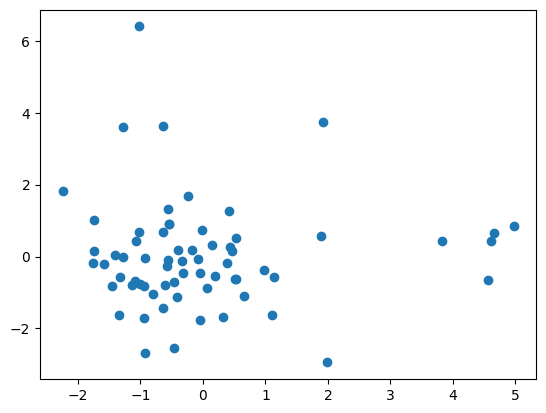

In [18]:
" Low dimensional plot of the neodes x features"

PCA_model = sklearn.decomposition.PCA(n_components=2)

lowdimension_embedding = PCA_model.fit_transform(embedding)

plt.scatter(lowdimension_embedding[:,0], lowdimension_embedding[:,1])
plt.show()

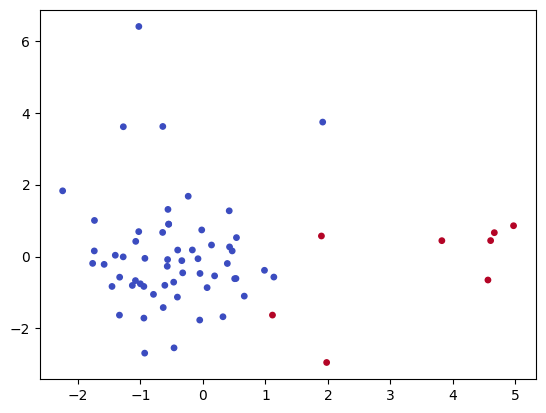

In [19]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2)
yhat = model.fit_predict(embedding)

" Low dimensional plot of the neodes x features"

PCA_model = sklearn.decomposition.PCA(n_components=2)

lowdimension_embedding = PCA_model.fit_transform(embedding)

plt.scatter(lowdimension_embedding[:,0], lowdimension_embedding[:,1], c=yhat,
            s=15,cmap='coolwarm')
plt.show()

In [20]:
results = pd.DataFrame()

results['rxn'] = G.nodes
results['cluster'] = yhat

for row in range(len(results)):
    results['rxn'].iloc[row] = le.inverse_transform([results['rxn'].iloc[row] ])

results[results['cluster'] == 1]

,rxn,cluster
31,[kg:reaction_glun],1
7,[kg:reaction_akgdh],1
8,[kg:reaction_akgt2r],1
18,[kg:reaction_fba],1
45,[kg:reaction_nh4t],1
57,[kg:reaction_succt2_2],1
64,[kg:reaction_tkt2],1
63,[kg:reaction_tkt1],1


In [23]:
print("Network density:", nx.density(G))

Network density: 0.1571095571095571


__The density value implies that this is not very dense network (on a scale from 0-1).__

In [24]:
from operator import itemgetter

betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
(55, 0.20566531960124193)
(32, 0.1493775865354674)
(26, 0.10793805243147293)
(39, 0.10157196847860955)
(14, 0.07734356579354533)
(52, 0.06638313387799333)
(11, 0.0645645492566243)
(43, 0.06288496800836187)
(53, 0.04669919059538695)
(29, 0.037334977594722145)
(0, 0.03518172548561663)
(48, 0.03076923076923077)
(16, 0.028179697039468356)
(46, 0.024822029010291454)
(60, 0.01950646314105271)
(13, 0.015739749004061495)
(62, 0.014453188198886767)
(30, 0.013609297304869893)
(54, 0.013586645631176165)
(3, 0.011396983803947396)


In [25]:
pagerank_dict = nx.pagerank(G)
sorted_pagerank = sorted(pagerank_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by page rank:")
for b in sorted_pagerank[:20]:
    print(b)

Top 20 nodes by page rank:
(55, 0.05182984606486342)
(32, 0.0468626523906143)
(14, 0.03502540147991287)
(43, 0.03182919418278747)
(11, 0.03144333112545613)
(52, 0.028646805741565043)
(39, 0.02801238030423723)
(26, 0.02755776678460108)
(53, 0.02662467208882875)
(16, 0.023591579569685477)
(46, 0.02128736610662002)
(13, 0.020399730306932692)
(3, 0.019232288031188545)
(35, 0.019232288031188545)
(62, 0.01860360222257138)
(54, 0.018167646981421468)
(0, 0.01681213857109116)
(30, 0.0165749322940504)
(60, 0.016000495000243007)
(29, 0.01562762387107402)


In [76]:
pageRank = pd.DataFrame()

pageRank['rxn'] = le.inverse_transform(list(pagerank_dict.keys()))
pageRank['value'] = list(pagerank_dict.values())

pageRank.sort_values(by=['value'], ascending=False)

,rxn,value
5,kg:reaction_pyk,0.051830
4,kg:reaction_glusy,0.046863
35,kg:reaction_cytbd,0.035025
6,kg:reaction_nadh16,0.031829
10,kg:reaction_atps4r,0.031443
...,...,...
25,kg:reaction_adk1,0.007697
54,kg:reaction_pgi,0.007235
61,kg:reaction_nh4t,0.006520
8,kg:reaction_acaldt,0.006438
